Runaway diagnostics for CeBr(A) detector

In [ ]:
import matplotlib.pyplot as plt     # modul pro "vykreslování grafů"

import numpy as np
import matplotlib as mpl
import os
from scipy.signal import find_peaks, peak_widths    # práce se signály
from matplotlib.ticker import AutoMinorLocator
from lmfit import Parameters,minimize, fit_report
import re

In [2]:
shot_no = 0 
#shot number for current shot use 0

In [3]:
mpl.rcParams['font.size']=16
mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.linewidth']=2
mpl.rcParams['axes.labelsize']=18
mpl.rcParams['axes.labelweight']='bold'
mpl.rcParams['lines.linewidth']=2
mpl.rcParams['legend.fontsize'] = 10

In [4]:
import requests

url = f"http://golem.fjfi.cvut.cz/shots/{shot_no}/Production/Parameters/FullCommandLine"

try:
    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Get the HTML content as a string
        html_content = response.text

        # Now you can work with the HTML content as a string
        print(html_content)
    else:
        print(f"Error: Unable to fetch the HTML content. Status code: {response.status_code}")

except requests.RequestException as e:
    print(f"Error: {e}")

Well-arranged command line form:

./Dirigent.sh \ 
--discharge --operation.discharge "style='fullsteam',vacuum_shot='-1'" \n--infrastructure.bt_ecd "U_Bt=800,t_Bt=1000,O_Bt='CW',U_cd=500,t_cd=1000,O_cd='CW'" \n--infrastructure.preionization "S_device='HotCathode',SW_main='on',U_heater=100,U_accel=70" \n--infrastructure.workinggas "S_mode='U_v',S_gas='H',p_H=15,U_v=22" \n--infrastructure.positionstabilization "main_switch='on',radial_switch='on',radial_waveform='1000,0;4000,-5;5000,-15;8000,-20;30000,0',vertical_switch='on',vertical_waveform='1000,0;5000,-7;7000,-15;10000,-20;30000,0'" \n--infrastructure.biasingelectrode "main_switch='on',waveform='1000,0;2000,-10;5000,0;6000,0;14000,0',position=100" \n--diagnostics.scintillationprobes "U_NIM_A1=600,U_NIM_A2=600,U_NIM_A3=600,U_NIM_A4=600" \n--diagnostics.limitermirnovcoils "vacuum_shot=-1" \n--diagnostics.langballpenprobe "r_lp_tip='83'" \n--diagnostics.doublerakeprobe "r_First_Tip=100,X_mod='111111111111',I_SilverBox=12" \n--diagnostic

In [5]:
# Your command line

# Regular expression pattern to match U_NIM_A2
pattern = r"U_NIM_A2=(\d+)"

# Use re.search to find the match
match = re.search(pattern, html_content)

# Check if the match is found
if match:
    # Extract the value of U_NIM_A2
    u_nim_a2_value = match.group(1)
    print(f"The value of U_NIM_A2 is: {u_nim_a2_value}")
else:
    print("U_NIM_A2 not found in the command line.")

The value of U_NIM_A2 is: 600


In [6]:
# wfm reader proof-of-concept
# https://www.tek.com/sample-license
# reads volts vs. time records (including fastframes) from little-endian version 3 WFM files

# See Also
# Performance Oscilloscope Reference Waveform File Format
# Tektronix part # 077-0220-10
# https://www.tek.com/oscilloscope/dpo7000-digital-phosphor-oscilloscope-manual-4

import struct
import time
import numpy as np # http://www.numpy.org/

class WfmReadError(Exception):
    """error for unexpected things"""
    pass

def read_wfm(target):
    """return sample data from target WFM file"""
    with open(target, 'rb') as f:
        hbytes = f.read(838)
        meta = decode_header(hbytes)
        # file signature checks
        if meta['byte_order'] != 0x0f0f:
            raise WfmReadError('big-endian not supported in this example')
        if meta['version'] != b':WFM#003':
            raise WfmReadError('only version 3 wfms supported in this example')
        if meta['imp_dim_count'] != 1:
            raise WfmReadError('imp dim count not 1')
        if meta['exp_dim_count'] != 1:
            raise WfmReadError('exp dim count not 1')
        if meta['record_type'] != 2:
            raise WfmReadError('not WFMDATA_VECTOR')
        if meta['exp_dim_1_type'] != 0:
            raise WfmReadError('not EXPLICIT_SAMPLE')
        if meta['time_base_1'] != 0:
            raise WfmReadError('not BASE_TIME')
        tfrac_array = np.zeros(meta['Frames'], dtype=np.double)
        tdatefrac_array = np.zeros(meta['Frames'], dtype=np.double)
        tdate_array = np.zeros(meta['Frames'], dtype=np.int32)
        tfrac_array[0] = meta['tfrac']
        tdatefrac_array[0] = meta['tdatefrac']
        tdate_array[0] = meta['tdate']
        # if fastframe, read fastframe table
        if meta['fastframe'] == 1:
            WUSp = np.fromfile(f, dtype='i4,f8,f8,i4', count=(meta['Frames'] - 1))
            # merge first frame trigger infos with frames > 1
            tfrac_array[1:] = WUSp['f1']
            tdatefrac_array[1:] = WUSp['f2']
            tdate_array[1:] = WUSp['f3']
        # read curve block
        bin_wave = np.memmap(filename = f,
                             dtype = meta['dformat'],
                             mode = 'r',
                             offset = meta['curve_offset'],
                             shape = (meta['avilable_values'], meta['Frames']),
                             order = 'F')
        # close file
    # slice out buffer values
    bin_wave = bin_wave[meta['pre_values']:meta['avilable_values'] - meta['post_values'],:]
    scaled_array = bin_wave * meta['vscale'] + meta['voffset']
    return scaled_array, meta['tstart'], meta['tscale'], tfrac_array, tdatefrac_array, tdate_array

def decode_header(header_bytes):
    """returns a dict of wfm metadata"""
    wfm_info = {}
    if len(header_bytes) != 838:
        raise WfmReadError('wfm header bytes not 838')
    wfm_info['byte_order'] = struct.unpack_from('H', header_bytes, offset=0)[0]
    wfm_info['version'] = struct.unpack_from('8s', header_bytes, offset=2)[0]
    wfm_info['imp_dim_count'] = struct.unpack_from('I', header_bytes, offset=114)[0]
    wfm_info['exp_dim_count'] = struct.unpack_from('I', header_bytes, offset=118)[0]
    wfm_info['record_type'] = struct.unpack_from('I', header_bytes, offset=122)[0]
    wfm_info['exp_dim_1_type'] = struct.unpack_from('I', header_bytes, offset=244)[0]
    wfm_info['time_base_1'] = struct.unpack_from('I', header_bytes, offset=768)[0]
    wfm_info['fastframe'] = struct.unpack_from('I', header_bytes, offset=78)[0]
    wfm_info['Frames'] = struct.unpack_from('I', header_bytes, offset=72)[0] + 1
    wfm_info['summary_frame'] = struct.unpack_from('h', header_bytes, offset=154)[0]
    wfm_info['curve_offset'] = struct.unpack_from('i', header_bytes, offset=16)[0] # 838 + ((frames - 1) * 54)
    # scaling factors
    wfm_info['vscale'] = struct.unpack_from('d', header_bytes, offset=168)[0]
    wfm_info['voffset'] = struct.unpack_from('d', header_bytes, offset=176)[0]
    wfm_info['tstart'] = struct.unpack_from('d', header_bytes, offset=496)[0]
    wfm_info['tscale'] = struct.unpack_from('d', header_bytes, offset=488)[0]
    # trigger detail
    wfm_info['tfrac'] = struct.unpack_from('d', header_bytes, offset=788)[0] # frame index 0
    wfm_info['tdatefrac'] = struct.unpack_from('d', header_bytes, offset=796)[0] # frame index 0
    wfm_info['tdate'] = struct.unpack_from('I', header_bytes, offset=804)[0] # frame index 0
    # data offsets
    # frames are same size, only first frame offsets are used
    dpre = struct.unpack_from('I', header_bytes, offset=822)[0]
    wfm_info['dpre'] = dpre
    dpost = struct.unpack_from('I', header_bytes, offset=826)[0]
    wfm_info['dpost'] = dpost
    readbytes = dpost - dpre
    wfm_info['readbytes'] = readbytes
    allbytes = struct.unpack_from('I', header_bytes, offset=830)[0]
    wfm_info['allbytes'] = allbytes
    # sample data type detection
    code = struct.unpack_from('i', header_bytes, offset=240)[0]
    wfm_info['code'] = code
    bps = struct.unpack_from('b', header_bytes, offset=15)[0]  # bytes-per-sample
    wfm_info['bps'] = bps
    if code == 7 and bps == 1:
        dformat = 'int8'
        samples = readbytes
    elif code == 0 and bps == 2:
        dformat = 'int16'
        samples = readbytes // 2
    elif code == 4 and bps == 4:
        dformat = 'single'
        samples = readbytes // 4
    else:
        raise WfmReadError('data type code or bytes-per-sample not understood')
    wfm_info['dformat'] = dformat
    wfm_info['samples'] = samples
    wfm_info['avilable_values'] = allbytes // bps
    wfm_info['pre_values'] = dpre // bps
    wfm_info['post_values'] = (allbytes - dpost) // bps
    return wfm_info




In [7]:
def readwfm(path):
    volts, tstart, tscale, tfrac, tdatefrac, tdate = read_wfm(path)
    toff = tfrac * tscale
    samples, frames = volts.shape
    tstop = samples * tscale + tstart
    volts = volts.reshape(len(volts))
    time = np.linspace(tstart+toff, tstop+toff, num=samples, endpoint=False)
    
    return time,volts

In [8]:
ds = np.DataSource('/tmp')  # temporary storage for downloaded files
data_URL = f'http://golem.fjfi.cvut.cz/shots/{shot_no}/Devices/Oscilloscopes/TektrMSO58-a/ch4.wfm'
fname = ds.open(data_URL).name
print(fname)


D:\tmp\golem.fjfi.cvut.cz\shots\0\Devices\Oscilloscopes\TektrMSO58-a\ch4.wfm


In [9]:

res=[]

In [10]:
time, volts=readwfm(fname)
max_value=np.max(-volts*1e3)
threshold = 0.1 * max_value
locs, peaks = find_peaks(-volts*1e3,prominence=threshold,distance=50) 
res.append(-volts[locs]*1e3)

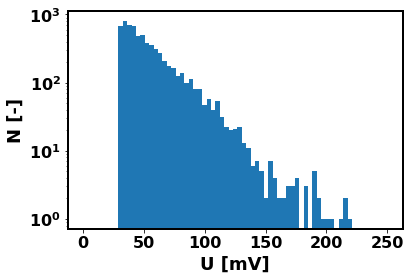

In [11]:
result=np.concatenate( res, axis=0 )
    
fig, ax = plt.subplots()

amp_bins = np.linspace(0,250,70)

n, edges, __ = ax.hist(result,bins=amp_bins)
centre=(edges[1:]+edges[:-1])/2
#mask=centre>60
#n=n[mask]
#centre=centre[mask]




ax.set_xlabel('U [mV]')
ax.set_ylabel('N [-]')

ax.title.set_text('')
ax.set_yscale('log')
plt.show()

In [12]:
a=1593.78
b=-6.19274
c=-0.384572
d=0.00572227
f=0.00111747

voldet=float(u_nim_a2_value)

x=voldet



def VoltoeV(z):
    return -(a + b*x +  d*x**2-z)/(c+f*x)

eV=VoltoeV(centre)

minus_bordel=n>2
eV=eV[minus_bordel]
n=n[minus_bordel]
print(eV)

mask=eV>eV[np.argmax(n)]
n=n[mask]
eV=eV[mask]

[324.03169336 336.70417213 349.37665091 362.04912968 374.72160845
 387.39408722 400.066566   412.73904477 425.41152354 438.08400231
 450.75648109 463.42895986 476.10143863 488.7739174  501.44639618
 514.11887495 526.79135372 539.46383249 552.13631126 564.80879004
 577.48126881 590.15374758 602.82622635 615.49870513 628.1711839
 640.84366267 653.51614144 666.18862022 678.86109899 691.53357776
 704.20605653 716.8785353  729.55101408 754.89597162 767.56845039
 805.58588671 818.25836548 830.93084426 856.2758018  881.62075935]


In [13]:
def fce(params,x,y):
        A = params['A']
        B = params['B']
        #C= params ['C']
        y_fit = A*np.exp(B*x)
        return y_fit-y
        
def fit(x,y):
    params = Parameters()

    params.add('A', min=100,max=1e15)
    params.add('B',min=-0.05,max=0)
    #params.add('C',min=0,max=0.001)

    fitted_params = minimize(fce, params, args=(x,y), method='least_squares')

    A = fitted_params.params['A'].value
    B = fitted_params.params['B'].value
    #C = fitted_params.params['C'].value    

    #print('\n---------------------lmit--------------------')
    #print(fit_report(fitted_params))
    return(A,B)

In [14]:
#Lower bound of the maximum runaway electron energy:

from scipy.optimize import minimize_scalar
A,B=fit(eV,n)
threshold_value=2
max_energy=np.log(threshold_value/A)/B
# Print the result
print(f"The function descends below {threshold_value} at eV = {max_energy}")

The function descends below 2 at eV = 860.2071175472938


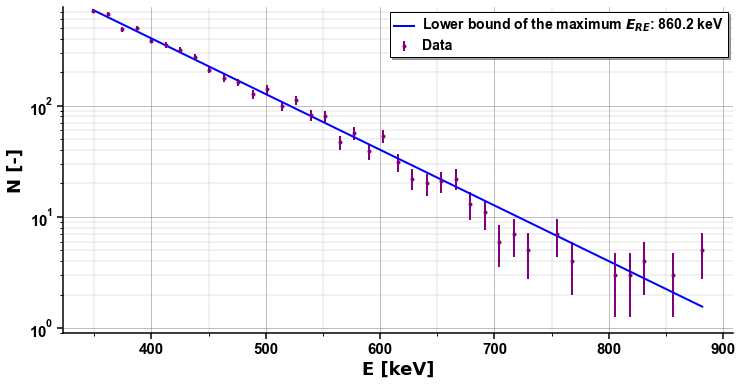

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
FONT='Arial'
ax.set_xlabel('E [keV]')
ax.set_ylabel('N [-]')
ax.errorbar(eV,n,fmt='.',yerr=np.sqrt(n),label=r'CeBr(B),$U_{{d}}={0:.0f}$'.format(voldet),color='purple') #sets the errorbar value to square root of counts for that value

eV_new=np.linspace(eV[0],eV[-1],1000)
A,B=fit(eV,n)
ax.plot(eV_new, A*np.exp(B*eV_new), color='blue',label=r"Lower bound of the maximum $E_{{RE}}$: {0:.1f} keV".format(max_energy))



#graphic parameters
plt.xticks(fontname=FONT, fontweight = 'bold', fontsize = 15)
plt.yticks(fontname=FONT, fontweight = 'bold', fontsize = 15)

ax.tick_params(which = 'major', direction='out', length=6, width=1.5)
ax.tick_params(which = 'minor', direction='out', length=3, width=1)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1.5)

ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

ax.grid(which = 'major', c = 'gray', linewidth = 0.5, linestyle = 'solid') 
ax.grid(which = 'minor', c = 'gray', linewidth = 0.3, linestyle = 'dashed')             

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

leg = plt.legend(  loc = 'best', shadow = True, fancybox=False)

leg.get_frame().set_linewidth(1)
leg.get_frame().set_edgecolor('k')

for text in leg.get_texts():
     plt.setp(text, fontname=FONT, fontsize = 14)

ax.title.set_text('')
ax.set_ylim(bottom=0.9)
ax.set_yscale('log')
#ax.set_xscale('log')
plt.savefig('icon-fig')
plt.show()

In [ ]:
res=[]


time, volts=readwfm(fname)
max_value=np.max(-volts*1e3)
threshold = 0.1 * max_value
locs, peaks = find_peaks(-volts*1e3,prominence=threshold,distance=50) 
#res.append(-volts[locs]*1e3)
res.append(time[locs])



result=np.concatenate( res, axis=0 )
print(np.max(result))
fig, ax = plt.subplots()
print()
amp_bins = np.linspace(np.min(result),np.max(result),70)

n, edges, __ = ax.hist(result,bins=amp_bins)
centre=(edges[1:]+edges[:-1])/2
mask=centre>60
n=n[mask]
centre=centre[mask]




ax.set_xlabel('t [s]')
ax.set_ylabel('N [-]')

ax.title.set_text('')
ax.set_yscale('log')